# Loopy Belief Propagation

Consider the following factor graph representation of a PGM in four variables $x_1, x_2, x_3, x_4$:

![image](../Figures/loopy_factor_graph.png)

Assume that the variables are discrete with four states $x_i \in \{1, 2, 3, 4\}$.
We wish to infer the marginal probabilities $p(x_i)$ for $i = 1, 2, 3, 4$ when the pairwise potential functions are given by

$$
[f_a(x_1, x_2)]_{x_1, x_2=1}^4 = [f_b(x_1, x_3)]_{x_1, x_3=1}^4 = [f_c(x_2, x_3)]_{x_2, x_3=1}^4 = [f_d(x_3, x_4)]_{x_3, x_4=1}^4 = \Psi,
$$

where $\Psi$ is a randomly generated $4 \times 4$ matrix.
Since the graph is clearly not tree-structured, standard belief propagation does not apply. Hence, we opt to run loopy belief propagation in hope that the result converges.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os

os.chdir('..')
from factorgraph import FactorGraph, VariableNode, FactorNode, Potential
from algorithms import LoopyBP


# Generate a random matrix Psi, corresponding to the pairwise potential functions
np.random.seed(0)
Psi = np.random.uniform(size=(4,4))


First, let's compute the exact solution by brute force for comparison.

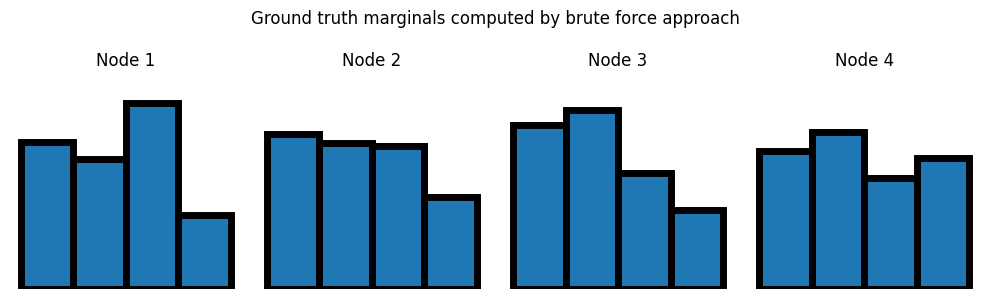

In [2]:
# Construct the joint probability distribution, which is a normalised product of the potentials
f_a = Psi[:,:,None,None] # Shape (4, 4, 1, 1)
f_b = Psi[:,None,:,None] # Shape (4, 1, 4, 1)
f_c = Psi[None,:,:,None] # Shape (1, 4, 4, 1)
f_d = Psi[None,None,:,:] # Shape (1, 1, 4, 4)

joint_probability = f_a * f_b * f_c * f_d # Shape (4, 4, 4, 4)
Z = joint_probability.sum() # Compute normalisation constant
joint_probability /= Z # Normalise to yield a valid probability mass function

# Compute the marginal distributions directly
true_marginals = []
for i in range(4):
    p_i = joint_probability
    for j in range(4):
        if j != i:
            p_i = p_i.sum(axis=j, keepdims=True)
    p_i = p_i.squeeze() # Shape (4,)
    true_marginals.append(p_i)

# Plot true marginals
fig, axs = plt.subplots(1, 4, figsize=(10,3))
for i in range(4):
    axs[i].bar(np.arange(4), true_marginals[i], width=1.0, edgecolor='black', linewidth=5, alpha=1.0)
    axs[i].set_title(f"Node {i+1}")
    axs[i].set_ylim([0,0.4])
    axs[i].set_axis_off()
plt.suptitle("Ground truth marginals computed by brute force approach")
plt.tight_layout()

Next, we compute approximations to these marginals by running loopy belief propagation on the factor graph.

In [3]:
# Set up factor graph corresponding to the figure above
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4], node_type="variable")
G.add_nodes_from(["a", "b", "c", "d"], node_type="factor")
G.add_edges_from([(1, "a"), (1, "b"), (2, "a"), (2, "c"), (3, "b"), (3, "c"), (3, "d"), (4, "d")])

# Set up variable nodes
num_states = 4
variable_keys = [1, 2, 3, 4]
variable_vals = [VariableNode(num_states) for _ in variable_keys]
variables = dict(zip(variable_keys, variable_vals))

# Set up factor nodes
factor_keys = ["a", "b", "c", "d"]
factor_vals = [FactorNode( Potential(Psi,list(G.neighbors(factorID))) ) for factorID in factor_keys]
factors = dict(zip(factor_keys, factor_vals))


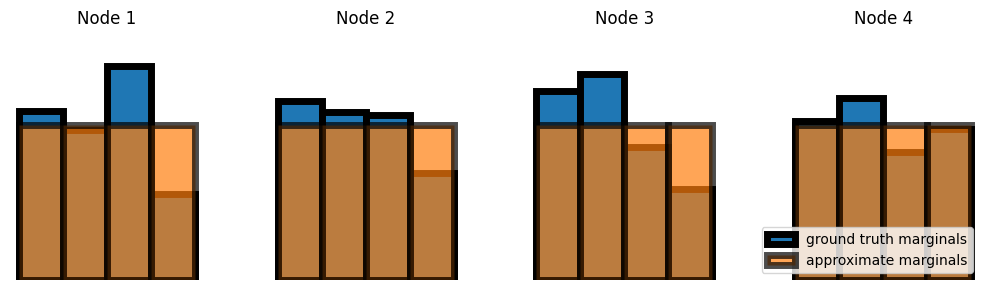

In [11]:
# Set up factor graph
f = FactorGraph(G, variables, factors)
f.reset()

# Plot initialisation
def plot(factor_graph: FactorGraph, ground_truth=None):
    fig, axs = plt.subplots(1, 4, figsize=(10,3))
    for i in range(4):
        if ground_truth is not None:
            axs[i].bar(np.arange(4), ground_truth[i], width=1.0, edgecolor='black', linewidth=5, alpha=1.0, label='ground truth marginals')
        state = factor_graph.variables[i+1].state
        state /= state.sum()
        axs[i].bar(np.arange(4), state, width=1.0, edgecolor='black', linewidth=5, alpha=0.7, label='approximate marginals')
        axs[i].set_title(f"Node {i+1}")
        axs[i].set_ylim([0,0.4])
        axs[i].set_axis_off()
    plt.legend(loc='lower right')
    plt.tight_layout()

plot(f, true_marginals)

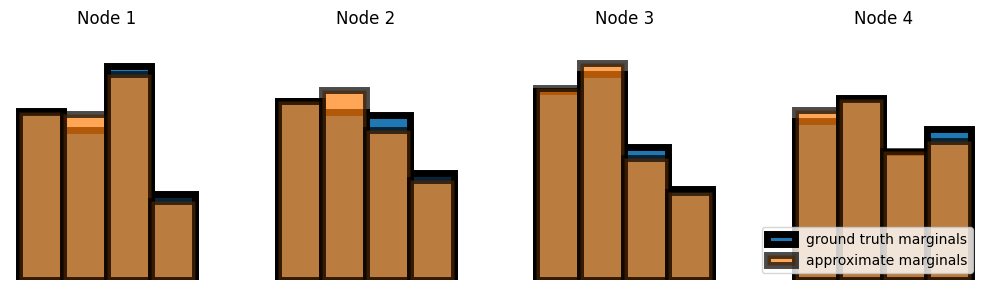

In [12]:
# First iteration of loopy belief propagation (using flooding schedule)
LoopyBP(f, reset=True)
plot(f, true_marginals)

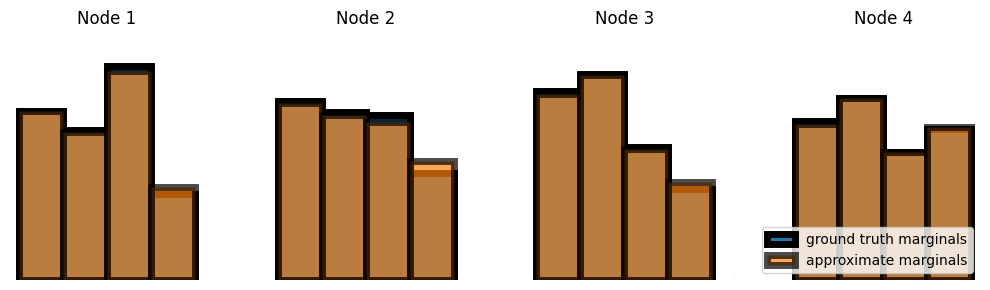

In [13]:
# Second iteration of loopy BP
LoopyBP(f)
plot(f, true_marginals)

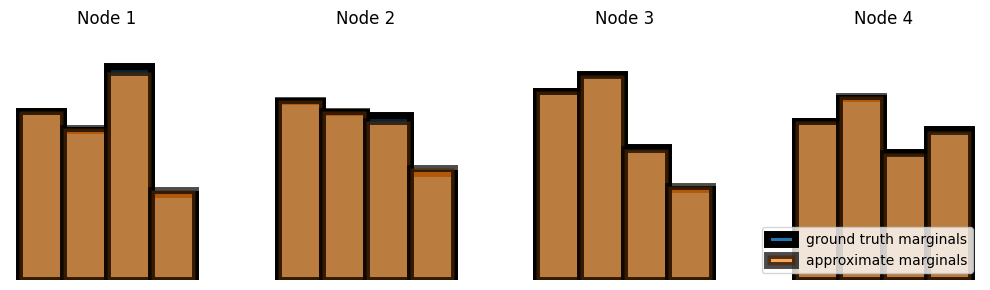

In [14]:
# Third iteration of loopy BP
LoopyBP(f)
plot(f, true_marginals)

We see that after only three iterations, the approximations obtained by loopy belief propagation are already reasonably close to the true marginals!